# Support Resistance Lines

In [ ]:
!pip install mplfinance pandas_ta

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
import scipy
import math
import pandas_ta as ta

data loaded
calculating resistance levels
analyzing signals


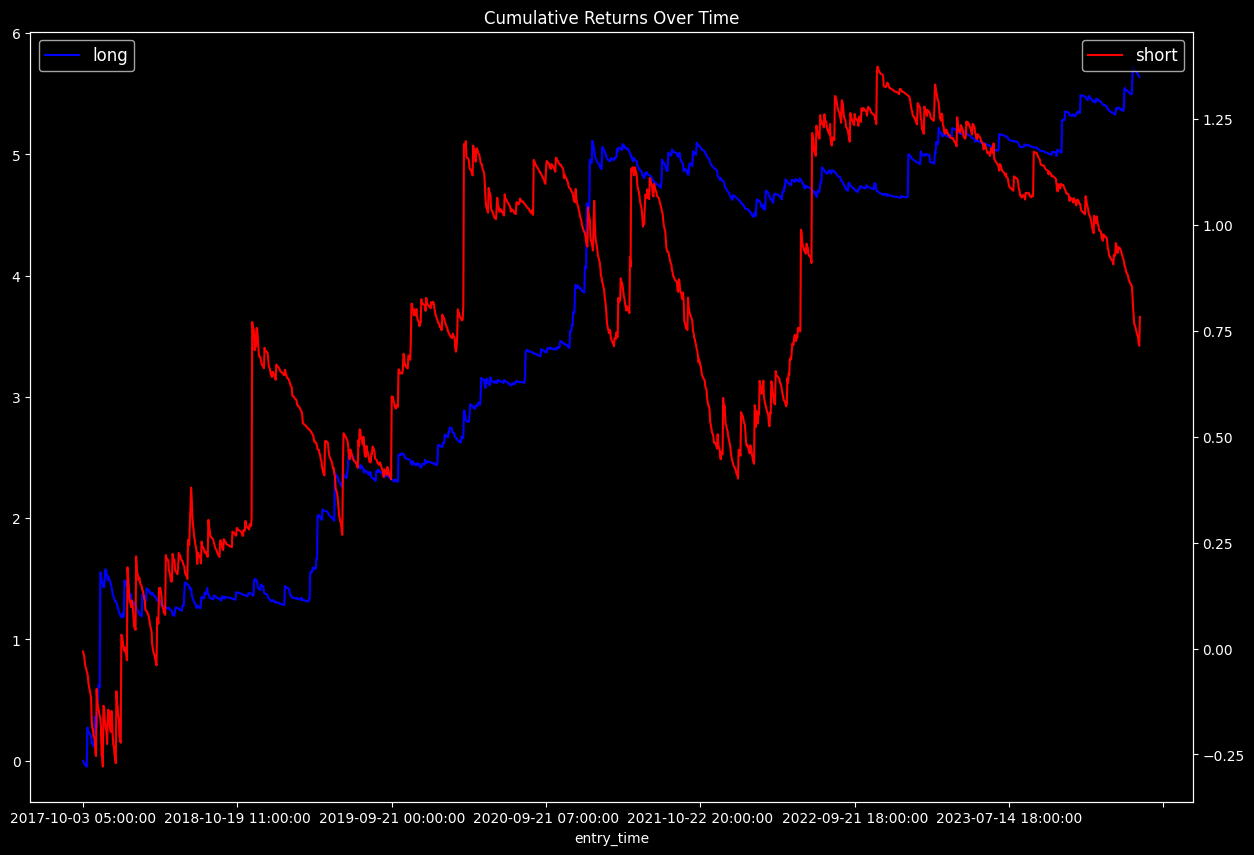

In [62]:
def find_levels( 
        price: np.array, atr: float, # Log closing price, and log atr 
        first_w: float = 0.1, 
        atr_mult: float = 3.0, 
        prom_thresh: float = 0.1
):

    # Setup weights
    last_w = 1.0
    w_step = (last_w - first_w) / len(price)
    weights = first_w + np.arange(len(price)) * w_step
    weights[weights < 0] = 0.0

    # Get kernel of price. 
    kernal = scipy.stats.gaussian_kde(price, bw_method=atr*atr_mult, weights=weights)

    # Construct market profile
    min_v = np.min(price)
    max_v = np.max(price)
    step = (max_v - min_v) / 200
    price_range = np.arange(min_v, max_v, step)
    pdf = kernal(price_range) # Market profile

    # Find significant peaks in the market profile
    pdf_max = np.max(pdf)
    prom_min = pdf_max * prom_thresh

    peaks, props = scipy.signal.find_peaks(pdf, prominence=prom_min)
    levels = [] 
    for peak in peaks:
        levels.append(np.exp(price_range[peak]))

    return levels, peaks, props, price_range, pdf, weights




# def support_resistance_levels(
#         data: pd.DataFrame, lookback: int, 
#         first_w: float = 0.01, atr_mult:float=3.0, prom_thresh:float =0.25
# ):
#     # Get log average true range, 
#     atr = ta.atr(np.log(data['high']), np.log(data['low']), np.log(data['close']), lookback)
#     all_levels = [None] * len(data)
#     for i in range(lookback, len(data)):
#         i_start  = i - lookback
#         vals = np.log(data.iloc[i_start+1: i+1]['close'].to_numpy())
#         levels, peaks, props, price_range, pdf, weights= find_levels(vals, atr.iloc[i], first_w, atr_mult, prom_thresh)
#         all_levels[i] = levels
#     return all_levels
def support_resistance_levels(data: pd.DataFrame, lookback: int, first_w: float = 0.01, atr_mult: float = 3.0, prom_thresh: float = 0.25):
    # Calculate log values upfront to avoid recalculating in each loop iteration
    log_high = np.log(data['high'])
    log_low = np.log(data['low'])
    log_close = np.log(data['close'])

    # Calculate ATR on log prices using a vectorized approach if possible
    atr = ta.atr(log_high, log_low, log_close, lookback)

    # Pre-allocate all levels list for better memory management
    all_levels = [None] * len(data)

    # Use numpy arrays for faster operations in a loop
    for i in range(lookback, len(data)):
        i_start = i - lookback
        vals = log_close.iloc[i_start + 1:i + 1].to_numpy()

        # Call to a potentially optimized find_levels function
        levels, peaks, props, price_range, pdf, weights = find_levels(vals, atr.iloc[i], first_w, atr_mult, prom_thresh)
        all_levels[i] = levels

    return all_levels

def sr_penetration_signal(data: pd.DataFrame, levels: list):
    signal = np.zeros(len(data))
    curr_sig = 0.0
    close_arr = data['close'].to_numpy()
    for i in range(1, len(data)):
        if levels[i] is None:
            continue

        last_c = close_arr[i - 1]
        curr_c = close_arr[i]

        for level in levels[i]:
            if curr_c > level and last_c <= level: # Close cross above line
                curr_sig = 1.0
            elif curr_c < level and last_c >= level: # Close cross below line
                curr_sig = -1.0

        signal[i] = curr_sig
    return signal

def get_trades_from_signal(data: pd.DataFrame, signal: np.array):
    long_trades = []
    short_trades = []

    close_arr = data['close'].to_numpy()
    last_sig = 0.0
    open_trade = None
    idx = data.index
    for i in range(len(data)):
        if signal[i] == 1.0 and last_sig != 1.0: # Long entry
            if open_trade is not None:
                open_trade[2] = idx[i] 
                open_trade[3] = close_arr[i]
                short_trades.append(open_trade)

            open_trade = [idx[i], close_arr[i], -1, np.nan]
        if signal[i] == -1.0  and last_sig != -1.0: # Short entry
            if open_trade is not None:
                open_trade[2] = idx[i] 
                open_trade[3] = close_arr[i]
                long_trades.append(open_trade)

            open_trade = [idx[i], close_arr[i], -1, np.nan]

        last_sig = signal[i]

    long_trades = pd.DataFrame(long_trades, columns=['entry_time', 'entry_price', 'exit_time', 'exit_price'])
    short_trades = pd.DataFrame(short_trades, columns=['entry_time', 'entry_price', 'exit_time', 'exit_price'])

    long_trades['percent'] = (long_trades['exit_price'] - long_trades['entry_price']) / long_trades['entry_price'] 
    short_trades['percent'] = -1 * (short_trades['exit_price'] - short_trades['entry_price']) / short_trades['entry_price']
    long_trades = long_trades.set_index('entry_time')
    short_trades = short_trades.set_index('entry_time')
    return long_trades, short_trades 



    return long_df, short_df
if __name__ == '__main__':

    df = pd.read_csv("../../datasets/universe.csv")
    print("data loaded")
    
    data = df[df['ticker'] == 'BTCUSDT'].copy()
    # data = df[df['ticker'] == 'ETHUSDT'].copy()
    # data = df[df['ticker'] == 'DOGEUSDT'].copy()
    # data = df[df['ticker'] == 'SOLUSDT'].copy()
    data['date'] = pd.to_datetime(data['datetime'], format="mixed")
    data = data.set_index('datetime')
    data = data.dropna()
    
    
    print("calculating resistance levels")
    levels = support_resistance_levels(data, 365*3, first_w=1.0, atr_mult=3.0)
    # levels = support_resistance_levels(data, 365*24, first_w=1.0, atr_mult=3.0)
    
    print("analyzing signals")
    data['sr_signal'] = sr_penetration_signal(data, levels)
    data['log_ret'] = np.log(data['close']).diff().shift(-1)
    data['sr_return'] = data['sr_signal'] * data['log_ret']
    
    long_trades, short_trades = get_trades_from_signal(data, data['sr_signal'].to_numpy())

    # Calculate the cumulative sum for long and short trades
    long_trades['cumulative_return'] = long_trades['percent'].cumsum()
    short_trades['cumulative_return'] = short_trades['percent'].cumsum()
    
    # Plot the lines
    plt.figure(figsize=(15, 10))  # You can adjust the numbers to fit your specific needs
    plt.style.use('dark_background')
    # plt.plot(long_trades.index, long_trades['cumulative_return'], label='Long Trades Cumulative Return')
    # plt.plot(short_trades.index, short_trades['cumulative_return'], label='Short Trades Cumulative Return')
    ax = plt.gca()
    long_trades['cumulative_return'].plot(color='blue', label='long', ax=ax)
    ax2 = plt.twinx()
    short_trades['cumulative_return'].plot(color='red', label='short', ax=ax2)
    ax.legend(loc='upper left', fontsize='large')
    ax2.legend(loc='upper right', fontsize='large')
    
    # Formatting the plot
    plt.title('Cumulative Returns Over Time')


In [53]:
df = pd.read_csv("../../datasets/universe.csv")

In [54]:
data = df[df['ticker'] == 'BTCUSDT'].copy()
# data = df[df['ticker'] == 'ETHUSDT'].copy()
# data = df[df['ticker'] == 'DOGEUSDT'].copy()
# data = df[df['ticker'] == 'SOLUSDT'].copy()
data['date'] = pd.to_datetime(data['datetime'], format="mixed")
data = data.set_index('datetime')
data = data.dropna()
# data = data[data.index > '2021-01-01']

In [55]:
levels = support_resistance_levels(data, 365*2, first_w=1.0, atr_mult=3.0)
# levels = support_resistance_levels(data, 365*24, first_w=1.0, atr_mult=3.0)

data['sr_signal'] = sr_penetration_signal(data, levels)
data['log_ret'] = np.log(data['close']).diff().shift(-1)
data['sr_return'] = data['sr_signal'] * data['log_ret']

long_trades, short_trades = get_trades_from_signal(data, data['sr_signal'].to_numpy())

In [56]:
def prof_factor(trades):
    profits = trades.loc[trades['percent'] > 0, 'percent'].sum()
    losses = trades.loc[trades['percent'] < 0, 'percent'].abs().sum()
    return profits / losses if losses != 0 else float('inf')  # Avoid division by zero
def avg_return(trades):
    return trades['percent'].mean()
def winrate(trades):
    return trades[trades['percent'] > 0].shape[0] / trades.shape[0]
print("LONG Trades PF", prof_factor(long_trades))
print("LONG Trades AVG Ret", avg_return(long_trades))
print("LONG Trades Winrate", winrate(long_trades))
print("SHORT Trades PF", prof_factor(short_trades))
print("SHORT Trades AVG Ret", avg_return(short_trades))
print("SHORT Trades Winrate", winrate(short_trades))

LONG Trades PF 1.4392292216904468
LONG Trades AVG Ret 0.002259637154522022
LONG Trades Winrate 0.17860422405876952
SHORT Trades PF 1.006136867849164
SHORT Trades AVG Ret 3.252702991842392e-05
SHORT Trades Winrate 0.1642955484167049


Text(0.5, 1.0, 'Cumulative Returns Over Time')

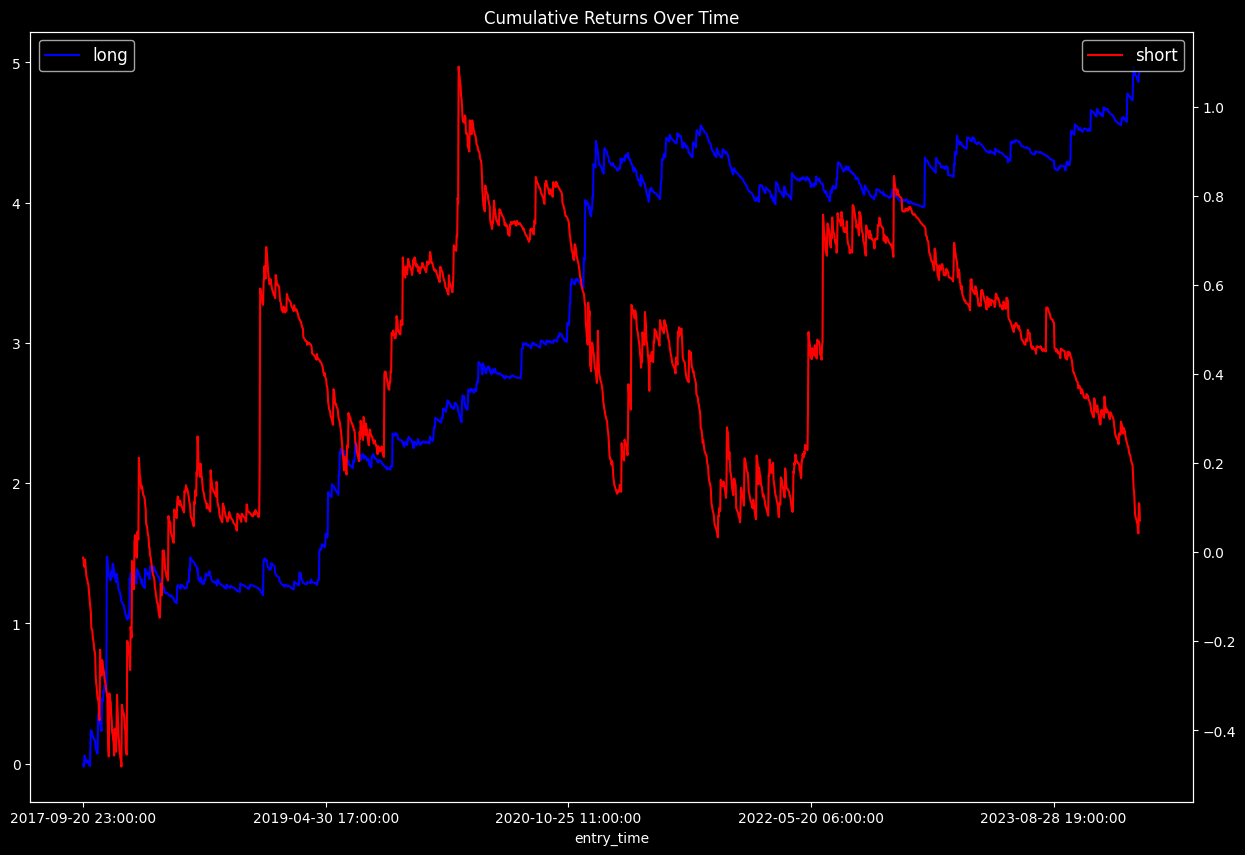

In [57]:
# # Assuming your DataFrame 'trades' has a 'datetime' column, a 'position' column with 'long' or 'short' values, and a 'percent' column for returns
# trades['cumulative_return'] = trades['percent'].cumsum()

# # Separate the long and short trades
# long_trades = trades[trades['position'] == 'long'].copy()
# short_trades = trades[trades['position'] == 'short'].copy()

# Calculate the cumulative sum for long and short trades
long_trades['cumulative_return'] = long_trades['percent'].cumsum()
short_trades['cumulative_return'] = short_trades['percent'].cumsum()

# Plot the lines
plt.figure(figsize=(15, 10))  # You can adjust the numbers to fit your specific needs
plt.style.use('dark_background')
# plt.plot(long_trades.index, long_trades['cumulative_return'], label='Long Trades Cumulative Return')
# plt.plot(short_trades.index, short_trades['cumulative_return'], label='Short Trades Cumulative Return')
ax = plt.gca()
long_trades['cumulative_return'].plot(color='blue', label='long', ax=ax)
ax2 = plt.twinx()
short_trades['cumulative_return'].plot(color='red', label='short', ax=ax2)
ax.legend(loc='upper left', fontsize='large')
ax2.legend(loc='upper right', fontsize='large')

# Formatting the plot
plt.title('Cumulative Returns Over Time')


In [ ]:
# print("LONG TRADES\n", long_trades)
# print("SHORT TRADES\n", short_trades)
# For demonstration, these lines would save the dataframes to CSV files.
long_trades.to_csv('long_trades.csv', index=False)
short_trades.to_csv('short_trades.csv', index=False)